# **Data Visualization**

## Objectives

* Business Requirement 1
    - 1 - The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* inputs/full_dataset/cherry-leaves/train
* inputs/full_dataset/cherry-leaves/validation
* inputs/full_dataset/cherry-leaves/test

## Outputs

* Image shape embeddings pkl file
* Mean and variability plots for images in each label
* Difference plot to show difference between healthy and powdery mildew leaves
* Generate code which will answer the business requirement
    - The code can be used for the streamlit dashboard. 

## Additional Comments

* No additional comments



---

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("whitegrid")
from matplotlib.image import imread

# Change working directory

In [2]:
import os
path = '/workspace/mildew-detector/jupyter_notebooks/'
os.chdir(path)
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detector/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current, working directory

In [4]:
working_dir = os.getcwd()
working_dir

'/workspace/mildew-detector'

Set inputs

In [5]:
my_data_dir = 'inputs/full_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

'inputs/full_dataset/cherry-leaves'

Set outputs

In [6]:
version ='v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print('Old ver is available. Create a new ver')
    pass
else:
    os.makedirs(name=file_path)

Old ver is available. Create a new ver


Set label name

In [7]:
labels = os.listdir(train_path)
print(f'Labels are: {labels}')

Labels are: ['healthy', 'powdery_mildew']


---

## Data Visualization

---

Image Shape
* Average image size on train set

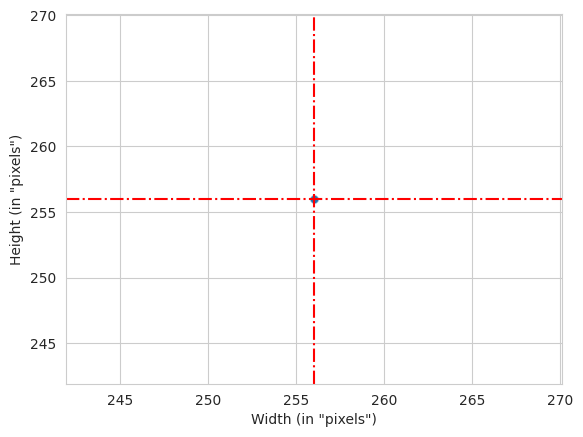

Width mean: 256px 
Height Mean: 256px


In [8]:
dim1,dim2 = [], []
for label in labels:
    for img_name in os.listdir(train_path+ '/' +label):
        img=imread(train_path+'/'+label+'/'+img_name)
        d1,d2,colors = img.shape
        dim1.append(d1) # height
        dim2.append(d2) # width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel('Width (in "pixels")')
axes.set_ylabel('Height (in "pixels")')
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='-.')
axes.axhline(y=dim2_mean,color='r', linestyle='-.')
plt.show()
print(f"Width mean: {dim2_mean}px \nHeight Mean: {dim1_mean}px")

In [9]:
img_shape = (dim1_mean,dim2_mean,3)
img_shape

(256, 256, 3)

Save the image shape embeddings

In [10]:
joblib.dump(value=img_shape ,
filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

## Mean and Variablility

* Function to load images in an array (keras library) and run the function

* Plot the mean and variability of images per label

In [11]:
from tensorflow.keras.preprocessing import image

def load_img_as_arr(my_data_dir, new_size=(50,50), n_images_per_label = 20):
    """
    This function creates two arrays. 
    One of the arrays has images and the other has labels. 
    n_images_per_label is a limit set to reduce time taken but can be changed.
    new_size is becuase we need to reduce size of image
    """

    X,y = np.array([], dtype='int'), np.array([], dtype='object')
    labels=os.listdir(my_data_dir)

    for label in labels:
        count = 0
        for img_name in os.listdir(my_data_dir + '/' + label):
            if count < n_images_per_label:
                img = image.load_img(my_data_dir + '/' + label +'/' + img_name, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)
                
                X=np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y=np.append(y,label)
                count += 1
    return X,y

In [12]:
X,y=load_img_as_arr(train_path,img_shape,30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


In [13]:
def plot_mean_var(X, y, figsize=(12,5), save_img=False):
  """
  This function will calculate mean & standard deviation, loop through labels,
  subset an array for each label, create mean/variability plots of the images 
  and then save the plots. 
  """

  for label_to_disp in np.unique(y):
    sns.set_style("white")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_disp,axis=1).reshape(-1)
    arr = X[boolean_mask]

    mean_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"---{label_to_disp}---")
    print(f"Image Shape: {mean_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for {label_to_disp} leaves")
    axes[0].imshow(mean_img, cmap='gray')
    axes[1].set_title(f"Variability Image for {label_to_disp} leaves")
    axes[1].imshow(std_img, cmap='gray')

    if save_img:
      plt.savefig(f"{file_path}/avg_var_{label_to_disp}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

---healthy---
Image Shape: (256, 256, 3)
---powdery_mildew---
Image Shape: (256, 256, 3)


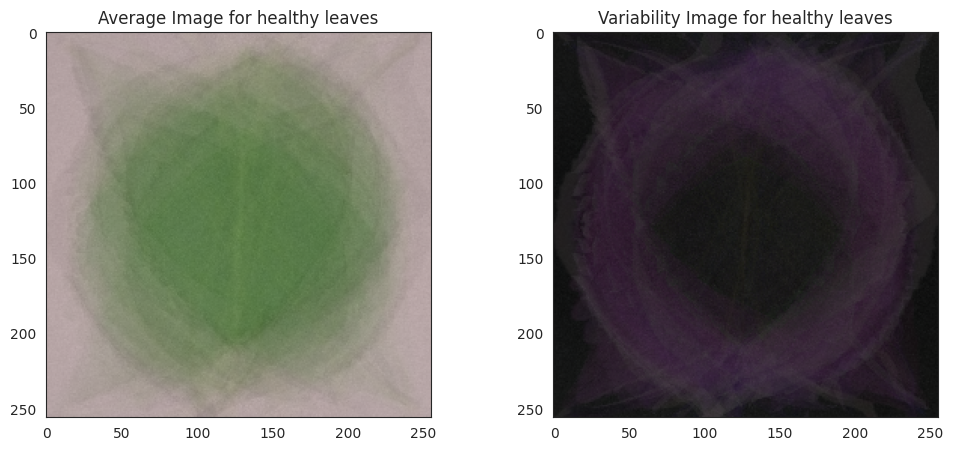

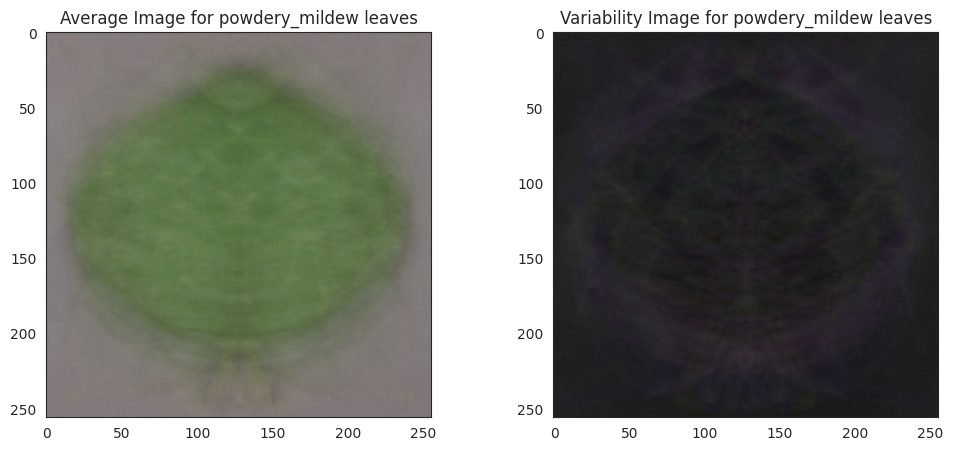

In [14]:
plot_mean_var(X, y, (12,5), True)

## Difference between average healthy and infected images

* Calculate and plot average image of healthy and powdery mildew 
* Difference between both images

In [15]:
def subset_img_label(X,y,label_to_disp):
    y=y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_disp,axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

def diff_as_arr(X,y,label_a,label_b,figsize=(20,5),save_img=False):
    sns.set_style('white')

    if (label_a not in np.unique(y)) or (label_b not in np.unique(y)):
        print(f"{label_a} or {label_b} are not in {np.unique(y)}")
        return
    #mean of label_a
    img_label = subset_img_label(X,y,label_a)
    label_a_mean = np.mean(img_label, axis=0)

    #mean of label_b
    img_label = subset_img_label(X,y,label_b)
    label_b_mean = np.mean(img_label, axis=0)

    #difference between average of label_a and label_b
    diff_mean = label_a_mean - label_b_mean

    #plot difference between avergae of label_a and label_b
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label_a_mean, cmap='gray')
    axes[0].set_title(f'Average: {label_a}')
    axes[1].imshow(label_b_mean, cmap='gray')
    axes[1].set_title(f'Average: {label_b}')
    axes[2].imshow(diff_mean, cmap='gray')
    axes[2].set_title(f'Difference: means of {label_a} and {label_b}')
    if save_img==True:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


outputs/v1


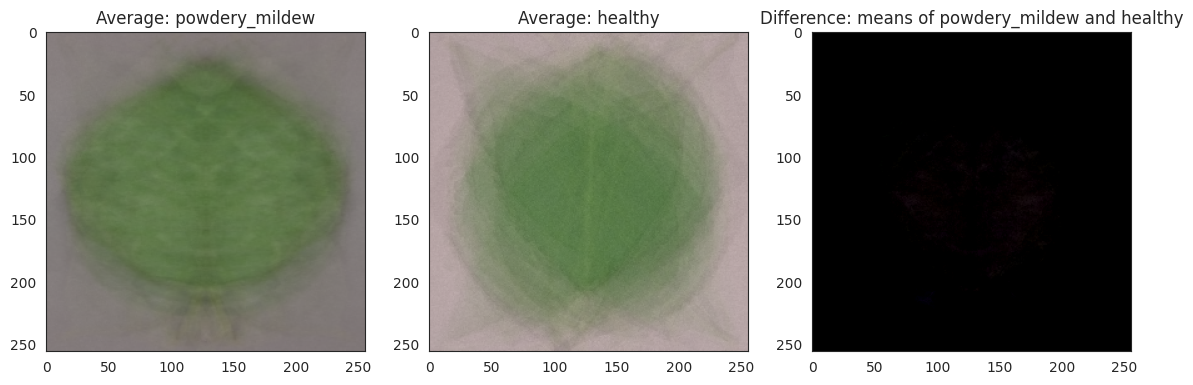

In [16]:
print(file_path)
diff_as_arr(X,y,'powdery_mildew', 'healthy', (14,10), save_img=True)

## Image Montage

* Create a montage of healthy and infected leaves

In [17]:
#set-up and imports
import itertools
import random
sns.set_style('white')

Function to create the montage

In [18]:
def img_mont(dir_path, label_to_disp, nrows, ncols, figsize=(15,10)):
    """
    This function will check if the label exists, the size of the subset, 
    create axes depending on how many rows and columns needed & display the images
    by creating a plot of a selection of images. 
    """
    labels = os.listdir(dir_path)
    if label_to_disp in labels:
        #check label
        img_list = os.listdir(dir_path+'/'+label_to_disp)
        #check size
        if nrows * ncols < len(img_list):
            img_idx = random.sample(img_list, nrows*ncols)
        else:
            print(
                f"You must decrease the number of rows or columns. \n"
                f"You asked for {nrows * ncols} spaces but "
                f"you currently have {len(imaged_list)} in your subset."
                )
            return
        
        #axes based on number of rows (r) and columns (c)
        list_r= range(0,nrows)
        list_c= range(0,ncols)
        plot_idx= list(itertools.product(list_r,list_c))
        #plot
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0,nrows*ncols):
            img = imread(dir_path + '/' + label_to_disp + '/' + img_idx[x])
            img_shape = img.shape 
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(f"Width {img_shape[1]}x Height {img_shape[0]} (pixels)")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()
    else:
        print('This label is non-existent')
        print(f'Choose from: {labels}')

Use the function to create the montage

healthy


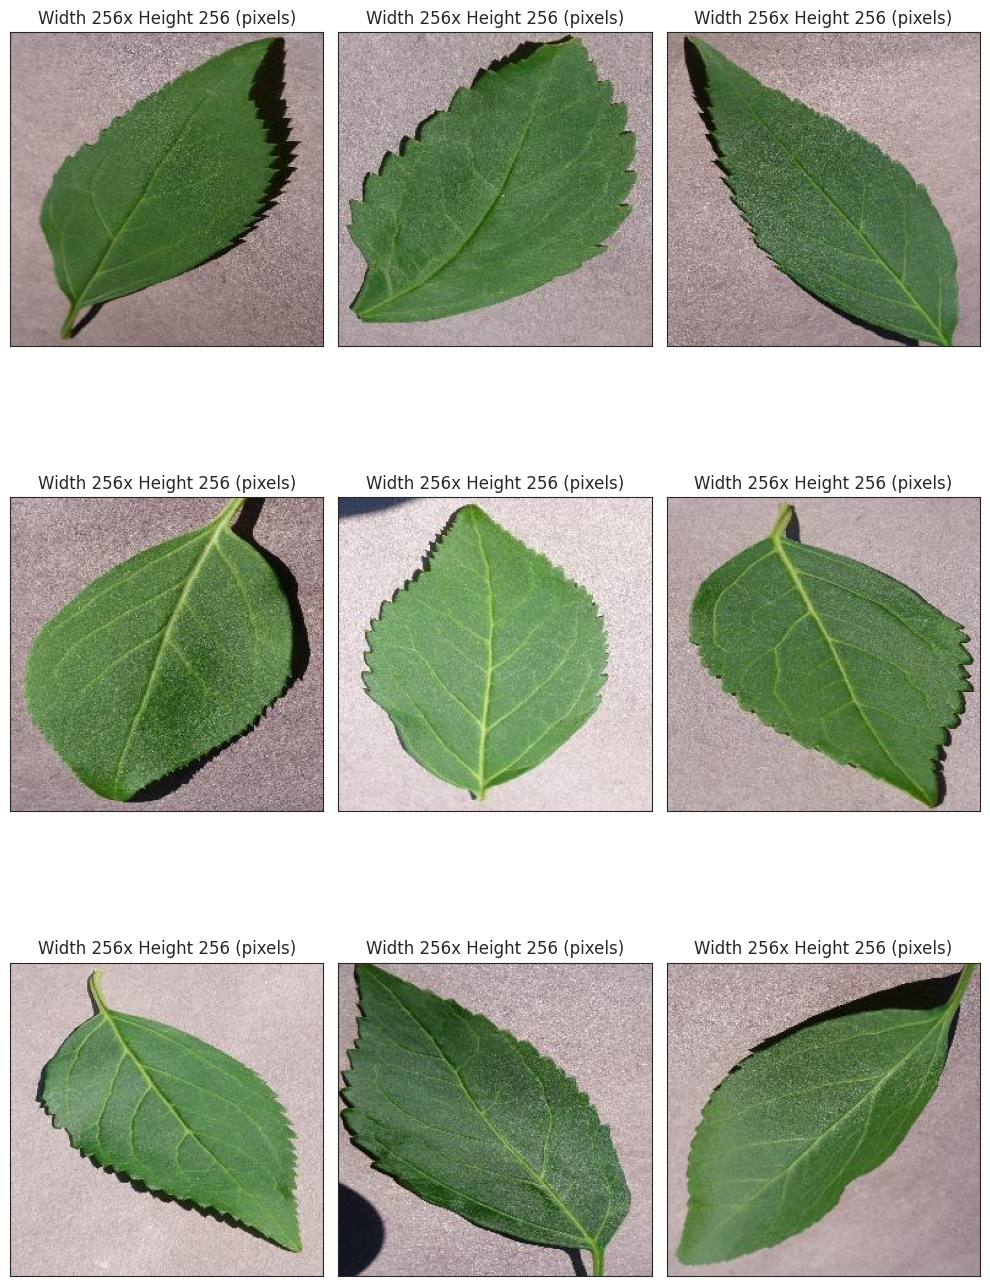

powdery_mildew


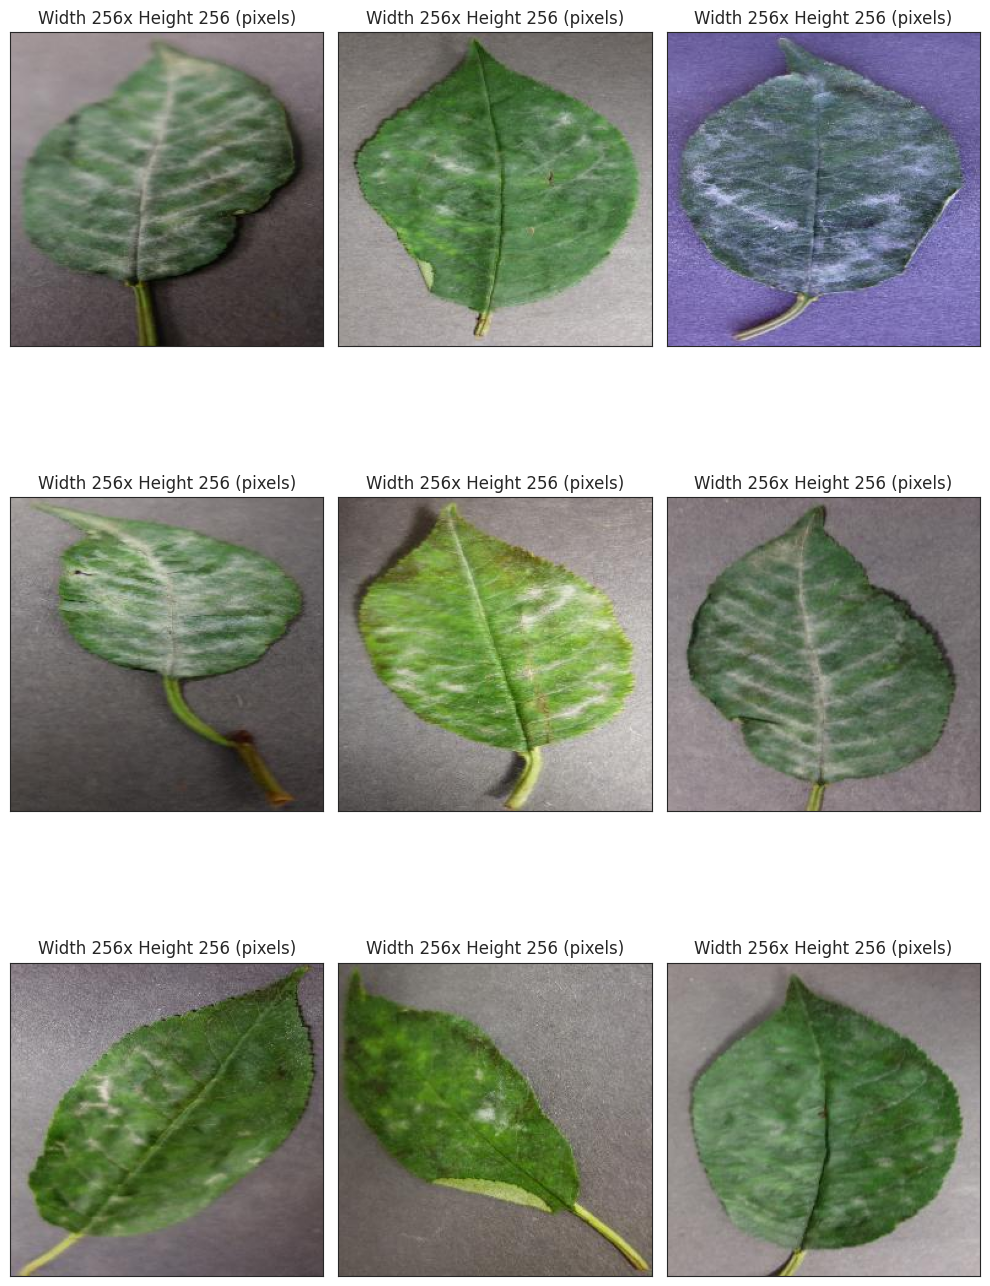

In [19]:
for label in labels:
    print(label)
    img_mont(train_path,label,3,3,(10,15))

---

## Conclusions

* Plots created of the mean and the variabilty of healthy and powdery mildew leaves.
* An image montage was created to show healthy and powdery mildew leaves.


---